In [1]:
%pylab inline
import re
from pathlib import Path
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
datdir = Path('data')
figdir = Path('plots')
figdir.mkdir(exist_ok=True)

In [3]:
mpl.rcParams.update({'figure.figsize': (2.5,1.75), 'figure.dpi': 300,
                     'axes.spines.right': False, 'axes.spines.top': False,
                     'axes.titlesize': 10, 'axes.labelsize': 10,
                     'legend.fontsize': 10, 'legend.title_fontsize': 10,
                     'xtick.labelsize': 8, 'ytick.labelsize': 8,
                     'font.family': 'sans-serif',  'font.sans-serif': ['Arial'],
                     'svg.fonttype': 'none', 'lines.solid_capstyle': 'round'})

# Figure 1 - Overview

In [4]:
df = pd.read_csv(datdir / 'fig_1.csv')
scores = df[list(map(str, range(20)))].values
selected = ~np.isnan(df['Selected'].values)

In [5]:
gens_sel = np.nonzero(selected)[0]
scores_sel = np.array([np.max(scores[g]) for g in gens_sel])
ims_sel = [plt.imread(str(datdir / 'images' / 'overview' / f'gen{gen:03d}.png'))
           for gen in gens_sel]
ims_sel = np.array(ims_sel)
print('gens to visualize:', gens_sel)
with np.printoptions(precision=2, suppress=True):
    print('corresponding scores:', scores_sel)
print('ims_sel shape:', ims_sel.shape)

gens to visualize: [  0   5  10  17  26  41  73 112 201 281]
corresponding scores: [ 6.41 13.27 19.27 26.69 32.4  40.35 45.97 54.07 61.09 68.52]
ims_sel shape: (10, 256, 256, 4)


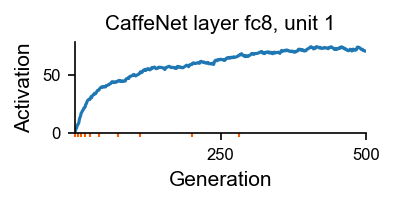

In [6]:
c0 = array((255,92,0)) / 255   # highlight color
figure(figsize=(2.5, 0.8), dpi=150)
plot(scores.mean(1))

xlim(0, 500)
ylim(bottom=0)
xticks((250,500))
yticks((0,50))
gca().set_xticks(np.nonzero(selected)[0], minor=True)
gca().tick_params(axis='x', which='minor', colors=c0, width=1)
title('CaffeNet layer fc8, unit 1')
xlabel('Generation')
ylabel('Activation')

savefig(figdir / f'overview-evo_scores.png', dpi=300, bbox_inches='tight')
savefig(figdir / f'overview-evo_scores.svg', dpi=300, bbox_inches='tight')

In [7]:
def make_canvas(ims, nrows=None, ncols=None, margin=15, margin_colors=None):
    if margin_colors is not None:
        assert len(ims) == len(margin_colors)
    if ncols is None:
        assert nrows is not None
        ncols = int(np.ceil(len(ims) / nrows))
    else:
        nrows = int(np.ceil(len(ims) / ncols))
    im0 = ims.__iter__().__next__()
    imsize = im0.shape[0]
    size = imsize + margin
    w = margin + size * ncols
    h = margin + size * nrows
    canvas = np.ones((h, w, 3), dtype=im0.dtype)
    for i, im in enumerate(ims):
        ih = i // ncols
        iw = i % ncols
        if len(im.shape) > 2 and im.shape[-1] == 4:
            im = im[..., :3]
        if margin_colors is not None:
            canvas[size * ih:size * (ih + 1) + margin, size * iw:size * (iw + 1) + margin] = margin_colors[i]
        canvas[margin + size * ih:margin + size * ih + imsize, margin + size * iw:margin + size * iw + imsize] = im
    return canvas

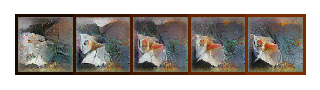

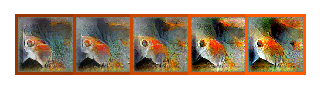

In [8]:
scores_sel_max = scores_sel.max()
margin_colors = np.array([(s / scores_sel_max * c0) for s in scores_sel])

for i, im_idc in enumerate((slice(0,5), slice(5,None))):
    canvas = make_canvas(ims_sel[im_idc], nrows=1,
                         margin_colors=margin_colors[im_idc])
    figure(dpi=150)
    imshow(canvas)
    
    # turn off axis decorators to make tight plot
    ax = gca()
    ax.tick_params(labelcolor='none', bottom=False, left=False, right=False)
    ax.set_frame_on(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    
    plt.imsave(figdir / f'overview-evo_ims_{i}.png', canvas)

# Define Custom Violinplot

In [9]:
def violinplot2(data=None, x=None, y=None, hue=None,
                palette=None, linewidth=1, orient=None,
                order=None, hue_order=None, x_disp=None,
                palette_per_violin=None, hline_at_1=True,
                legend_palette=None, legend_kwargs=None,
                width=0.7, control_width=0.8, control_y=None,
                hues_share_control=False,
                ax=None, **kwargs):
    """
    width: width of a group of violins ("hues") as fraction of between-group distance
    contorl_width: width of a group of bars (control) as fraction of hue width
    """
    if order is None:
        n_groups = len(set(data[x])) if orient != 'h' else len(set(data[y]))
    else:
        n_groups = len(order)
    extra_plot_handles = []
    if ax is None:
        ax = plt.gca()
    if orient == 'h':
        fill_between = ax.fill_betweenx
        plot = ax.vlines
    else:
        fill_between = ax.fill_between
        plot = ax.hlines

    ############ drawing ############
    if not isinstance(y, str) and hasattr(y, '__iter__'):
        ys = y
    else:
        ys = (y,)
    for y in ys:
        ax = sns.violinplot(data=data, x=x, y=y, hue=hue, ax=ax, 
                            palette=palette, linewidth=linewidth, orient=orient,
                            width=width, order=order, hue_order=hue_order, **kwargs)
    if legend_kwargs is not None:
        lgnd = plt.legend(**legend_kwargs)
    else:
        lgnd = None
    
    if hline_at_1:
        hdl = plot(1, -0.45, n_groups-0.55, linestyle='--', linewidth=.75, zorder=-3)
        extra_plot_handles.append(hdl)
    ############ drawing ############
    
    ############ styling ############
    if orient != 'h':
        ax.xaxis.set_ticks_position('none')
    if x_disp is not None:
        ax.set_xticklabels(x_disp)
    
    # enlarge the circle for median
    median_marks = [o for o in ax.get_children() if isinstance(o, matplotlib.collections.PathCollection)]
    for o in median_marks:
        o.set_sizes([10,])

    # recolor the violins
    violins = np.array([o for o in ax.get_children() if isinstance(o, matplotlib.collections.PolyCollection)])
    violins = violins[np.argsort([int(v.get_label().replace('_collection','')) for v in violins])]
    for i, o in enumerate(violins):
        if palette_per_violin is not None:
            i %= len(palette_per_violin)
            c = palette_per_violin[i]
            if len(c) == 2:
                o.set_facecolor(c[0])
                o.set_edgecolor(c[1])
            else:
                o.set_facecolor(c)
                o.set_edgecolor('none')
        else:
            o.set_edgecolor('none')
        
    # recolor the legend patches
    if lgnd is not None:
        for v in (legend_palette, palette_per_violin,  palette):
            if v is not None:
                legend_palette = v
                break
        if legend_palette is not None:
            for o, c in zip(lgnd.get_patches(), legend_palette):
                o.set_facecolor(c)
                o.set_edgecolor('none')
    ############ styling ############

    ############ control ############
    # done last to not interfere with coloring violins 
    if control_y is not None:
        assert control_y in df.columns
        assert hue is not None and order is not None and hue_order is not None
        nhues = len(hue_order)
        vw = width    # width per control (long)
        if not hues_share_control:
            vw /= nhues
        cw = vw * control_width    # width per control (short)
        ctl_hdl = None
        for i, xval in enumerate(order):
            if not hues_share_control:
                for j, hval in enumerate(hue_order):
                    df_ = df[(df[x] == xval) & (df[hue] == hval)]
                    if not len(df_):
                        continue
                    lq, mq, uq = np.nanpercentile(df_[control_y].values, (25, 50, 75))
                    xs_qtl = i + vw * (-nhues/2 + 1/2 + j) + cw/2 * np.array((-1,1))
                    xs_med = i + vw * (-nhues/2 + j) + vw * np.array((0,1))
                    ctl_hdl = fill_between(xs_qtl, lq, uq, color=(0.9,0.9,0.9), zorder=-2)    # upper & lower quartiles
                    plot(mq, *xs_med, color=(0.5,0.5,0.5), linewidth=1, zorder=-1)    # median
            else:
                df_ = df[(df[x] == xval)]
                if not len(df_):
                    continue
                lq, mq, uq = np.nanpercentile(df_[control_y].values, (25, 50, 75))
                xs_qtl = i + cw/2 * np.array((-1,1))
                xs_med = i + vw/2 * np.array((-1,1))
                ctl_hdl = fill_between(xs_qtl, lq, uq, color=(0.9,0.9,0.9), zorder=-2)
                plot(mq, *xs_med, color=(0.5,0.5,0.5), linewidth=1, zorder=-1)
        extra_plot_handles.append(ctl_hdl)
    ############ control ############
    
    return n_groups, ax, lgnd, extra_plot_handles


def default_ax_lims(ax, n_groups=None, orient=None):
    if orient == 'h':
        ax.set_xticks((0,1,2,3))
        ax.set_xlim(-0.25, 3.5)
    else:
        if n_groups is not None:
            ax.set_xlim(-0.65, n_groups-0.35)
        ax.set_yticks((0,1,2,3))
        ax.set_ylim(-0.25, 3.5)


def rotate_xticklabels(ax, rotation=10, pad=5):
    for i, tick in enumerate(ax.xaxis.get_major_ticks()):
        if tick.label.get_text() == 'none':
            tick.set_visible(False)
        tick.label.set(va='top', ha='center', rotation=rotation, rotation_mode='anchor')
        tick.set_pad(pad)

# Figure 3 - Compare Target Nets, Layers

In [10]:
df = pd.read_csv(datdir/'fig_2.csv')
df = df[~np.isnan(df['Rel_act'])]    # remove invalid data
df.head()

,Classifier,Layer,Unit,Rel_act,Evo_max_act,ImNet_max_act,ImNet_max_path,ImNet_expected_max_in_10k,Rel_exp_max
0,caffenet,conv2,4_13_13,1.235932,408.88956,330.83493,train/n04487394_328.JPEG,250.10214,0.755973
1,caffenet,conv2,5_13_13,0.523978,192.25589,366.91565,train/n07248320_80047.JPEG,248.14581,0.676302
2,caffenet,conv2,7_13_13,0.446260,170.44183,381.93430,train/n03271574_3882.JPEG,303.36743,0.794292
3,caffenet,conv2,8_13_13,1.041841,326.47418,313.36290,train/n04428191_36172.JPEG,231.95667,0.740217
4,caffenet,conv2,12_13_13,1.612245,216.18353,134.08847,train/n04517823_1665.JPEG,80.54089,0.600655


In [11]:
nets = ('caffenet', 'resnet-152-v2', 'resnet-269-v2', 'inception-v3', 'inception-v4', 'inception-resnet-v2', 'placesCNN')
layers = {'caffenet': ('conv2', 'conv4', 'fc6', 'fc8'),
          'resnet-152-v2': ('res15_eletwise', 'res25_eletwise', 'res35_eletwise', 'classifier'),
          'resnet-269-v2': ('res25_eletwise', 'res45_eletwise', 'res60_eletwise', 'classifier'),
          'inception-v3': ('pool2_3x3_s2', 'reduction_a_concat', 'reduction_b_concat', 'classifier'),
          'inception-v4': ('inception_stem3', 'reduction_a_concat', 'reduction_b_concat', 'classifier'),
          'inception-resnet-v2': ('stem_concat', 'reduction_a_concat', 'reduction_b_concat', 'classifier'),
          'placesCNN': ('conv2', 'conv4', 'fc6', 'fc8')}
get_layer_level = lambda r: ('Early', 'Middle', 'Late', 'Output')[layers[r[1]['Classifier']].index(r[1]['Layer'])]
df['Layer_level'] = list(map(get_layer_level, df.iterrows()))

x_disp = ('CaffeNet', 'ResNet-152-v2', 'ResNet-269-v2', 'Inception-v3', 'Inception-v4', 'Inception-ResNet-v2', 'PlacesCNN')
palette = get_cmap('Blues')(np.linspace(0.3,0.8,4))

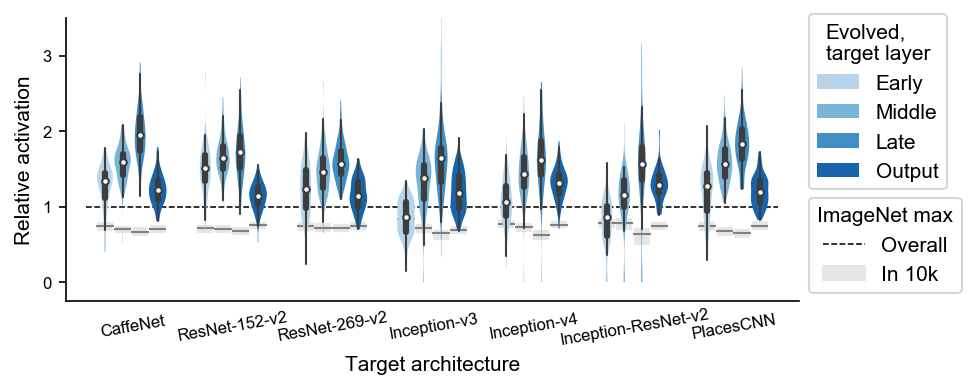

In [12]:
fig = figure(figsize=(6.3,2.5), dpi=150)
n_groups, ax, lgnd, hdls = violinplot2(
    data=df, x='Classifier', y='Rel_act', hue='Layer_level', cut=0,
    order=nets, hue_order=('Early', 'Middle', 'Late', 'Output'), x_disp=x_disp,
    legend_kwargs=dict(title='Evolved,\ntarget layer', loc='upper left', bbox_to_anchor=(1,1.05)),
    palette_per_violin=palette, control_y='Rel_exp_max')

default_ax_lims(ax, n_groups)
rotate_xticklabels(ax)
ylabel('Relative activation')
xlabel('Target architecture')

# another legend
legend(handles=hdls, labels=['Overall', 'In 10k'], title='ImageNet max',
           loc='upper left', bbox_to_anchor=(1,0.4))
ax.add_artist(lgnd)

savefig(figdir / f'nets.png', dpi=300, bbox_inches='tight')
savefig(figdir / f'nets.svg', dpi=300, bbox_inches='tight')

# Figure 5 - Compare Generators

## Compare representation "depth"

In [13]:
df = pd.read_csv(datdir / 'fig_5-repr_depth.csv')
df = df[~np.isnan(df['Rel_act'])]
df['Classifier, layer'] = [', '.join(tuple(a)) for a in df[['Classifier', 'Layer']].values]
df.head()

,Generator,Classifier,Layer,Unit,Rel_act,Rel_exp_max,"Classifier, layer"
0,raw_pixel,caffenet,conv2,4_13_13,1.259173,0.755973,"caffenet, conv2"
1,raw_pixel,caffenet,conv2,5_13_13,0.627591,0.676302,"caffenet, conv2"
2,raw_pixel,caffenet,conv2,7_13_13,0.835810,0.794292,"caffenet, conv2"
3,raw_pixel,caffenet,conv2,8_13_13,1.268967,0.740217,"caffenet, conv2"
4,raw_pixel,caffenet,conv2,12_13_13,1.376858,0.600655,"caffenet, conv2"


In [14]:
nets = ('caffenet', 'inception-resnet-v2')
layers = {'caffenet': ('conv2', 'fc6', 'fc8'), 
          'inception-resnet-v2': ('classifier',)}
generators = ('raw_pixel', 'deepsim-norm1', 'deepsim-norm2', 'deepsim-conv3',
              'deepsim-conv4', 'deepsim-pool5', 'deepsim-fc6', 'deepsim-fc7', 'deepsim-fc8')

xorder = ('caffenet, conv2', 'caffenet, fc6', 'caffenet, fc8', 'inception-resnet-v2, classifier')
x_disp = ('CaffeNet, conv2', 'CaffeNet, fc6', 'CaffeNet, fc8', 'Inception-ResNet-v2,\nclassifier')
lbl_disp = ('Raw pixel',) + tuple(v.replace('deepsim', 'DeePSiM') for v in generators[1:])
palette = ([[0.75, 0.75, 0.75]] +    # raw pixel
           sns.husl_palette(len(generators)-1, h=0.05, l=0.65))    # deepsim 1--8

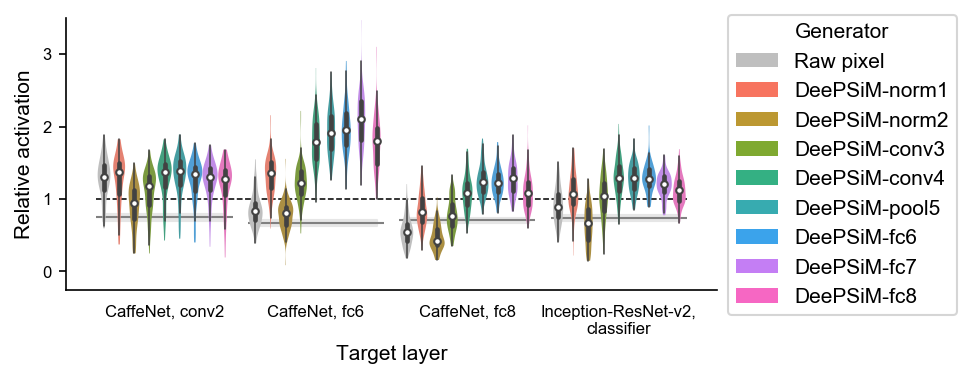

In [15]:
fig = figure(figsize=(5.6,2.4), dpi=150)
n_groups, ax, lgnd, hdls = violinplot2(
    data=df, x='Classifier, layer', y='Rel_act', hue='Generator',
    cut=0, linewidth=.75, width=0.9, control_width=0.9,
    order=xorder, hue_order=generators, x_disp=x_disp,    
    legend_kwargs=dict(title='Generator', loc='upper left', bbox_to_anchor=(1,1.05)),
    palette=palette, control_y='Rel_exp_max', hues_share_control=True)

default_ax_lims(ax, n_groups)
ylabel('Relative activation')
xlabel('Target layer')

# change legend label text
for txt, lbl in zip(lgnd.get_texts(), lbl_disp):
    txt.set_text(lbl)

savefig(figdir / f'generators.png', dpi=300, bbox_inches='tight')
savefig(figdir / f'generators.svg', dpi=300, bbox_inches='tight')

## Compare training dataset

In [16]:
df = pd.read_csv(datdir / 'fig_5-training_set.csv')
df = df[~np.isnan(df['Rel_act'])]
df['Classifier, layer'] = [', '.join(tuple(a)) for a in df[['Classifier', 'Layer']].values]
df.head()

,Generator,Classifier,Layer,Unit,Rel_act,Rel_exp_max,"Classifier, layer"
0,deepsim-fc6,caffenet,conv2,4_13_13,1.235932,0.755973,"caffenet, conv2"
1,deepsim-fc6,caffenet,conv2,5_13_13,0.523978,0.676302,"caffenet, conv2"
2,deepsim-fc6,caffenet,conv2,7_13_13,0.446260,0.794292,"caffenet, conv2"
3,deepsim-fc6,caffenet,conv2,8_13_13,1.041841,0.740217,"caffenet, conv2"
4,deepsim-fc6,caffenet,conv2,12_13_13,1.612245,0.600655,"caffenet, conv2"


In [17]:
nets = ('caffenet', 'inception-resnet-v2')
cs = ('caffenet', 'placesCNN', 'inception-resnet-v2')
layers = {c: ('conv2', 'conv4', 'fc6', 'fc8') for c in cs}
layers['inception-resnet-v2'] = ('classifier',)
gs = ('deepsim-fc6', 'deepsim-fc6-places365')
cls = ('caffenet, conv2', 'caffenet, conv4', 'caffenet, fc6', 'caffenet, fc8', 'inception-resnet-v2, classifier',
       'placesCNN, conv2', 'placesCNN, conv4', 'placesCNN, fc6', 'placesCNN, fc8')
cls_spaced = cls[:5] + ('none',) + cls[5:]

x_disp = tuple(f'CaffeNet, {v}' for v in ('conv2', 'conv4', 'fc6', 'fc8')) + \
         ('Inception-ResNet-v2,\nclassifier', 'none') + \
         tuple(f'PlacesCNN, {v}' for v in ('conv2', 'conv4', 'fc6', 'fc8'))
lbl_disp = ('DeePSiM-fc6', 'DeePSiM-fc6-Places365')
palette = [get_cmap(main_c)(np.linspace(0.3,0.8,4))
           for main_c in ('Blues', 'Oranges')]
palette = list(np.array(palette).transpose(1,0,2).reshape(-1, 4))
palette = palette + palette[-2:] + palette

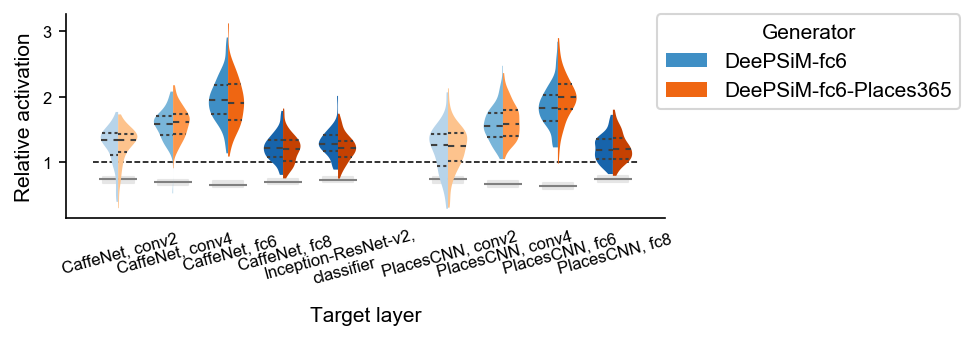

In [18]:
fig = figure(figsize=(5.15,1.8), dpi=150)
n_groups, ax, lgnd, hdls = violinplot2(
    data=df, x='Classifier, layer', y='Rel_act', hue='Generator',
    cut=0, split=True, inner='quartile',
    order=cls_spaced, hue_order=gs, x_disp=x_disp,
    legend_kwargs=dict(title='Generator', loc='upper left', bbox_to_anchor=(.97,1.05)),
    palette_per_violin=palette, legend_palette=palette[4:],
    control_y='Rel_exp_max', hues_share_control=True)

rotate_xticklabels(ax, rotation=15, pad=10)
ylabel('Relative activation')
xlabel('Target layer')

# change legend label text
for txt, lbl in zip(lgnd.get_texts(), lbl_disp):
    txt.set_text(lbl)

savefig(figdir / f'generators2.png', dpi=300, bbox_inches='tight')
savefig(figdir / f'generators2.svg', dpi=300, bbox_inches='tight')

# Figure 4 - Compare Inits

In [19]:
layers = ('conv2', 'conv4', 'fc6', 'fc8')
layers_disp = tuple(v.capitalize() for v in layers)

## Rand inits, fraction change

In [20]:
df = pd.read_csv(datdir/'fig_4-rand_init.csv').set_index(['Layer', 'Unit', 'Init_seed'])
df = (df.drop(0, level='Init_seed') - df.xs(0, level='Init_seed')).mean(axis=0,level=('Layer','Unit'))
df = df.rename({'Rel_act': 'Fraction change'}, axis=1)
df = df.reset_index()
df.head()

,Layer,Unit,Fraction change
0,conv2,101_13_13,-0.003135
1,conv2,103_13_13,0.067191
2,conv2,106_13_13,-0.039084
3,conv2,108_13_13,0.015845
4,conv2,109_13_13,-0.030982


In [21]:
palette = get_cmap('Blues')(np.linspace(0.2,0.9,6)[1:-1])

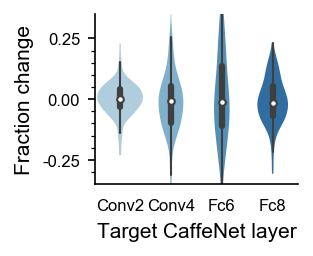

In [22]:
fig = figure(figsize=(1.75,1.5), dpi=150)
n_groups, ax, lgnd, hdls = violinplot2(
    data=df, x='Layer', y='Fraction change',
    cut=0, width=0.9, palette=palette,
    order=layers, x_disp=layers_disp, hline_at_1=False)

xlabel('Target CaffeNet layer')
ylim(-0.35, 0.35)
yticks((-0.25,0,0.25))
ax.set_yticklabels([f'{t:.2f}' for t in (-0.25,0,0.25)])
ax.set_yticks(np.arange(-0.3,0.30,0.05), minor=True)

savefig(figdir / f'inits-change.png', dpi=300, bbox_inches='tight')
savefig(figdir / f'inits-change.svg', dpi=300, bbox_inches='tight')

## Rand inits, interpolation

In [23]:
df = pd.read_csv(datdir/'fig_4-rand_init_interp.csv').set_index(['Layer', 'Unit', 'Seed_i0', 'Seed_i1'])
df = df.mean(axis=0,level=('Layer','Unit'))
df2 = pd.read_csv(datdir/'fig_4-rand_init_interp-2.csv').set_index(['Layer', 'Unit'])    # control conditions
df2_normed = df2.divide(df[['Rel_act_loc_0.0','Rel_act_loc_1.0']].mean(axis=1),axis=0)
df_normed = df.divide(df[['Rel_act_loc_0.0','Rel_act_loc_1.0']].mean(axis=1),axis=0)
df_normed.head()

Rel_act_loc_-0.5  Rel_act_loc_-0.375  Rel_act_loc_-0.25  \
Layer Unit                                                                
conv2 4_13_13           0.256651            0.418985           0.643095   
      5_13_13           0.325031            0.449016           0.626006   
      7_13_13           0.070683            0.265325           0.514847   
      8_13_13           0.438913            0.559851           0.705793   
      12_13_13         -0.061765            0.201633           0.523112   

                Rel_act_loc_-0.125  Rel_act_loc_0.0  Rel_act_loc_0.125  \
Layer Unit                                                               
conv2 4_13_13             0.892031         1.000284           0.938893   
      5_13_13             0.838808         1.005818           0.871105   
      7_13_13             0.803074         1.002402           0.789938   
      8_13_13             0.868285         0.987722           0.868131   
      12_13_13            0.827692         1.002151           0.875709   

                Rel_act_loc_0.25  Rel_act_loc_0.375  Rel_act_loc_0.5  \
Layer Unit                                                             
conv2 4_13_13           0.866663           0.814939         0.800847   
      5_13_13           0.672883           0.534458         0.496533   
      7_13_13           0.481916           0.245232         0.138952   
      8_13_13           0.666309           0.513182         0.442453   
      12_13_13          0.638728           0.494162         0.453965   

                Rel_act_loc_0.625  Rel_act_loc_0.75  Rel_act_loc_0.875  \
Layer Unit                                                               
conv2 4_13_13            0.822049          0.880937           0.952425   
      5_13_13            0.526762          0.641566           0.844714   
      7_13_13            0.171211          0.397102           0.749846   
      8_13_13            0.486103          0.647016           0.877945   
      12_13_13           0.485164          0.626201           0.877899   

                Rel_act_loc_1.0  Rel_act_loc_1.125  Rel_act_loc_1.25  \
Layer Unit                                                             
conv2 4_13_13          0.999716           0.908609          0.680847   
      5_13_13          0.994182           0.817431          0.608872   
      7_13_13          0.997598           0.757890          0.403745   
      8_13_13          1.012278           0.885931          0.717545   
      12_13_13         0.997849           0.836938          0.536125   

                Rel_act_loc_1.375  Rel_act_loc_1.5  
Layer Unit                                          
conv2 4_13_13            0.466013         0.295721  
      5_13_13            0.443034         0.317983  
      7_13_13            0.101559        -0.095873  
      8_13_13            0.573920         0.471014  
      12_13_13           0.227031        -0.026743

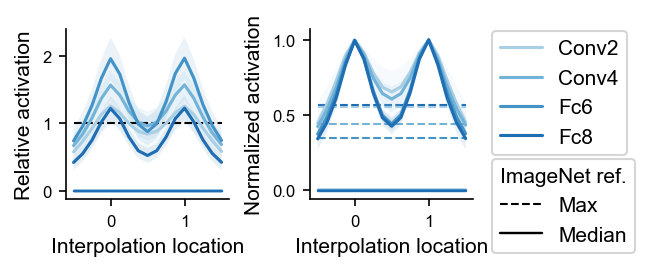

In [24]:
fig, axs = subplots(1, 2, figsize=(3.5,1.5), dpi=150)
subplots_adjust(wspace=0.5)

interp_xs = np.array([float(i[i.rfind('_')+1:]) for i in df.columns])
for ax, df_ in zip(axs, (df, df_normed)):
    df_mean = df_.mean(axis=0, level='Layer')
    df_std = df_.std(axis=0, level='Layer')
    for l, ld, c in zip(layers, layers_disp, palette):
        m = df_mean.loc[l].values
        s = df_std.loc[l].values
        ax.plot(interp_xs, m, c=c, label=ld)
        ax.fill_between(interp_xs, m-s, m+s, fc=c, ec='none', alpha=0.1)

# plot control
xs2 = (interp_xs.min(), interp_xs.max())
axs[0].hlines(1, *xs2, linestyle='--', linewidth=1)
for l, c in zip(layers, palette):
    # left subplot: relative activation
    df_ = df2.loc[l]
    mq = np.nanmedian(df_['Rel_ImNet_median_act'].values)
    axs[0].plot(xs2, (mq, mq), color=c, linewidth=1.15, zorder=-2)
    # right subplot: normalized to endpoints
    df_ = df2_normed.loc[l]
    for k, ls, lw in zip(('Rel_exp_max', 'Rel_ImNet_median_act'), ('--','-'), (1, 1.15)):
        mq = np.nanmedian(df_[k].values)
        axs[1].plot(xs2, (mq, mq), color=c, ls=ls, linewidth=lw, zorder=-2)
    
axs[0].set_yticks((0, 1, 2))
axs[1].set_yticks((0, 0.5, 1))
axs[0].set_ylabel('Relative activation')
axs[1].set_ylabel('Normalized activation')
for ax in axs:
    ax.set_xlabel('Interpolation location')
lgnd = axs[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 1.05))
legend(handles=[Line2D([0], [0], color='k', lw=1, ls='--', label='Max'),
                    Line2D([0], [0], color='k', lw=1.15, label='Median')],
           title='ImageNet ref.',
           loc='upper left', bbox_to_anchor=(1.05,0.3))
ax.add_artist(lgnd)

savefig(figdir / f'inits-interp.png', dpi=300, bbox_inches='tight')
savefig(figdir / f'inits-interp.svg', dpi=300, bbox_inches='tight')

## Per-neuron inits

In [25]:
df = pd.read_csv(datdir/'fig_4-per_neuron_init.csv')
df.head()

,Layer,Unit,Init_name,Rel_act,Rel_act_init
0,conv2,4_13_13,best_ivt,1.213874,0.836693
1,conv2,4_13_13,best_opt,1.263839,0.765940
2,conv2,4_13_13,mid_ivt,1.246766,0.059418
3,conv2,4_13_13,mid_opt,1.242509,0.139940
4,conv2,4_13_13,worst_ivt,1.210930,0.172832


In [26]:
hue_order = ('rand', 'none', 'worst_opt', 'mid_opt', 'best_opt',
             'worst_ivt', 'mid_ivt', 'best_ivt')
palette = [get_cmap(main_c)(np.linspace(0.3,0.8,4))
           for main_c in ('Blues', 'Greens', 'Purples')]
palette = np.concatenate([[
    palette[0][i]] * 1 + [palette[1][i]] * 3 + [palette[2][i]] * 3
    for i in range(4)])
palette = tuple(palette) + tuple(('none', c) for c in palette)

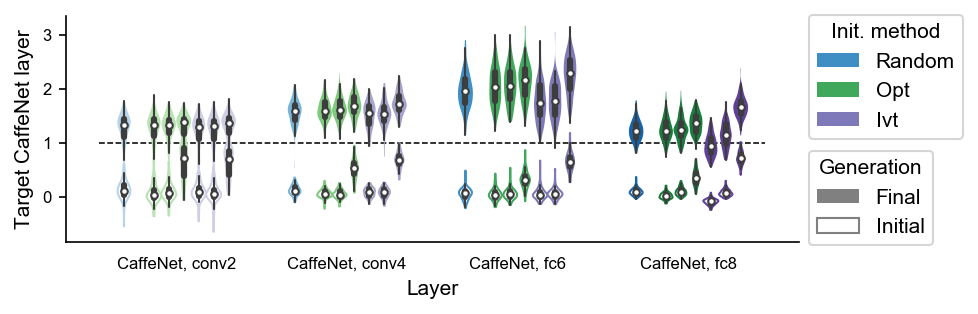

In [27]:
fig = figure(figsize=(6.3,2), dpi=150)

n_groups, ax, lgnd, hdls = violinplot2(
    data=df, x='Layer', y=('Rel_act', 'Rel_act_init'), hue='Init_name', cut=0,
    order=layers, hue_order=hue_order, x_disp=x_disp,
    palette_per_violin=palette)

ylabel('Relative activation')
ylabel('Target CaffeNet layer')

# create custom legends
# for init methods
legend_elements = [
    matplotlib.patches.Patch(facecolor=palette[14+3*i], edgecolor='none', label=l)
    for i, l in enumerate(('Random', 'Opt', 'Ivt'))]
lgnd1 = legend(handles=legend_elements, title='Init. method',
                   loc='upper left', bbox_to_anchor=(1,1.05))
# for generation condition
legend_elements = [
    matplotlib.patches.Patch(facecolor='gray', edgecolor='none', label='Final'),
    matplotlib.patches.Patch(facecolor='none', edgecolor='gray', label='Initial')]
ax.legend(handles=legend_elements, title='Generation',
          loc='upper left', bbox_to_anchor=(1,.45))
ax.add_artist(lgnd1)

savefig(figdir / f'inits-per_neuron.png', dpi=300, bbox_inches='tight')
savefig(figdir / f'inits-per_neuron.svg', dpi=300, bbox_inches='tight')

# Figure 6 - Compare Optimizers & Stoch Scales

## Compare optimizers

In [28]:
df = pd.read_csv(datdir/'fig_6-optimizers.csv')
df['OCL'] = ['_'.join(v) for v in df[['Optimizer','Classifier','Layer']].values]
df.head()

,Optimizer,Classifier,Layer,Unit,Noisy,Rel_act,Rel_exp_max,OCL
0,genetic,caffenet,conv2,4_13_13,False,1.235932,0.755973,genetic_caffenet_conv2
1,genetic,caffenet,conv2,5_13_13,False,0.523978,0.676302,genetic_caffenet_conv2
2,genetic,caffenet,conv2,7_13_13,False,0.446260,0.794292,genetic_caffenet_conv2
3,genetic,caffenet,conv2,8_13_13,False,1.041841,0.740217,genetic_caffenet_conv2
4,genetic,caffenet,conv2,12_13_13,False,1.612245,0.600655,genetic_caffenet_conv2


In [29]:
opts = ('genetic', 'FDGD', 'NES')
layers = {'caffenet': ('conv2', 'conv4', 'fc6', 'fc8'),
          'inception-resnet-v2': ('classifier',)}
cls = [(c, l) for c in layers for l in layers[c]]

xorder = tuple(f'{opt}_{c}_{l}' for c in layers for l in layers[c]
               for opt in (opts + ('none',)))[:-1]
x_disp = ('CaffeNet, conv2', 'CaffeNet, conv4', 'CaffeNet, fc6', 'CaffeNet, fc8',
          'Inception-ResNet-v2,\nclassifier')
opts_disp = ('Genetic', 'FDGD', 'NES')
palette = [get_cmap(main_c)(np.linspace(0.3,0.8,4))
           for main_c in ('Blues', 'Oranges', 'Greens')]
palette = np.concatenate([
    np.concatenate([[palette[j][i], palette[j][i]/2+0.5] for j in range(3)])
    for i in (0,1,2,3,3)])

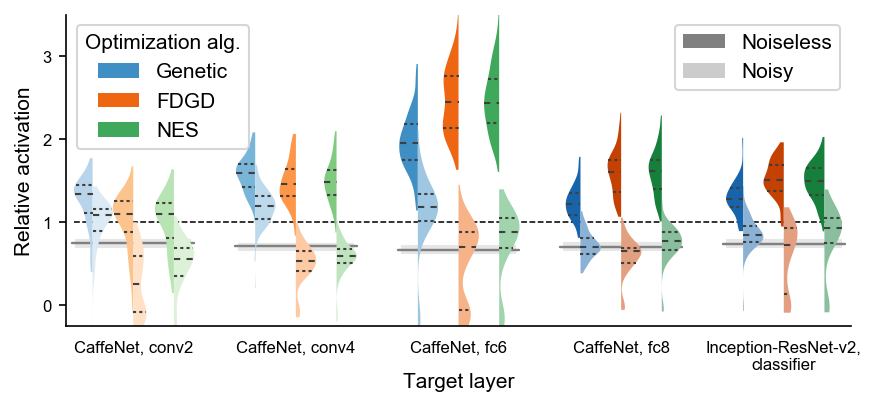

In [30]:
fig = figure(figsize=(6.75,2.75), dpi=150)
n_groups, ax, lgnd, hdls = violinplot2(
    data=df, x='OCL', y='Rel_act', hue='Noisy',
    cut=0, inner='quartiles', split=True, width=1,
    order=xorder, palette_per_violin=palette)

default_ax_lims(ax, n_groups)
xticks(np.arange(1,20,4), labels=x_disp)
xlabel('Target layer', labelpad=0)
ylabel('Relative activation')

# create custom legends
# for optimizers
legend_patches = [matplotlib.patches.Patch(facecolor=palette[i], edgecolor='none', label=opt)
                  for i, opt in zip(range(12,18,2), opts_disp)]
lgnd1 = legend(handles=legend_patches, title='Optimization alg.',
                   loc='upper left', bbox_to_anchor=(0,1))
# for noise condition
legend_patches = [matplotlib.patches.Patch(facecolor=(0.5,0.5,0.5), edgecolor='none', label='Noiseless'),
                  matplotlib.patches.Patch(facecolor=(0.8,0.8,0.8), edgecolor='none', label='Noisy')]
legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1,1))
ax.add_artist(lgnd1)

# plot control
group_width_ = 4
for i, cl in enumerate(cls):
    i = i * group_width_ + 1
    df_ = df[(df['Classifier'] == cl[0]) & (df['Layer'] == cl[1])]
    lq, mq, uq = np.nanpercentile(df_['Rel_exp_max'].values, (25, 50, 75))
    xs_qtl = i+np.array((-1,1))*group_width_*0.7/2
    xs_med = i+np.array((-1,1))*group_width_*0.75/2
    fill_between(xs_qtl, lq, uq, color=(0.9,0.9,0.9), zorder=-2)
    plot(xs_med, (mq, mq), color=(0.5,0.5,0.5), linewidth=1.15, zorder=-1)

savefig(figdir / f'optimizers.png', dpi=300, bbox_inches='tight')
savefig(figdir / f'optimizers.svg', dpi=300, bbox_inches='tight')

## Compare varying amounts of noise

In [31]:
df = pd.read_csv(datdir/'fig_6-stoch_scales.csv')
df = df[~np.isnan(df['Rel_noise'])]
df['Stoch_scale_plot'] = [str(int(v)) if ~np.isnan(v) else 'None' for v in df['Stoch_scale']]
df.head()

,Classifier,Layer,Unit,Stoch_scale,Rel_act,Rel_exp_max,Rel_noise,SNR,Self_correlation,Stoch_scale_plot
0,caffenet,conv2,4_13_13,5.0,1.040749,0.755973,0.473197,4.726425,0.145250,5
1,caffenet,conv2,5_13_13,5.0,0.347882,0.676302,0.752071,1.805515,0.044021,5
3,caffenet,conv2,8_13_13,5.0,0.773066,0.740217,0.537225,3.764263,0.241907,5
5,caffenet,conv2,15_13_13,5.0,0.998692,0.850692,0.435585,5.319523,0.078364,5
6,caffenet,conv2,16_13_13,5.0,0.835373,0.817110,0.483605,4.364254,0.095593,5


In [32]:
layers = ('conv2', 'conv4', 'fc6', 'fc8')
stoch_scales = list(map(str, (5, 10, 20, 50, 75, 100, 250))) + ['None']
stoch_scales_disp = stoch_scales[:-1] + ['No\nnoise']

stat_keys = ('Self_correlation', 'Rel_noise', 'SNR')
stat_keys_disp = ('Self correlation', 'Stdev. : mean ratio', 'Signal-to-noise ratio')
palette = [get_cmap('Blues')(np.linspace(0.3,0.8,4))[2]]   # to match previous color

In [33]:
# calculate noise statstics and define their formatting
format_frac = lambda v: ('%.2f' % v)[1:] if (0 < v < 1) else '0' if v == 0 else str(v)

def format_sci(v):
    v = '%.0e' % v
    if v == 'inf':
        return v
    m, s = v.split('e')
    s = int(s)
    if s:
        if False: #s > 1:
            m = re.split('0+$', m)[0]
            m += 'e%d' % s
        else:
            m = str(int((float(m) * np.power(10, s))))
    return m

fmts = (format_frac, format_frac, format_sci)

byl_byss_stats = {k: {} for k in stat_keys}
for l in layers:
    df_ = df[df['Layer'] == l]
    stats = {k: [] for k in stat_keys}
    for ss in stoch_scales:
        df__ = df_[df_['Stoch_scale_plot'] == ss]
        for k in stat_keys:
            stats[k].append(np.median(df__[k]))
    for k in stats.keys():
        byl_byss_stats[k][l] = stats[k]

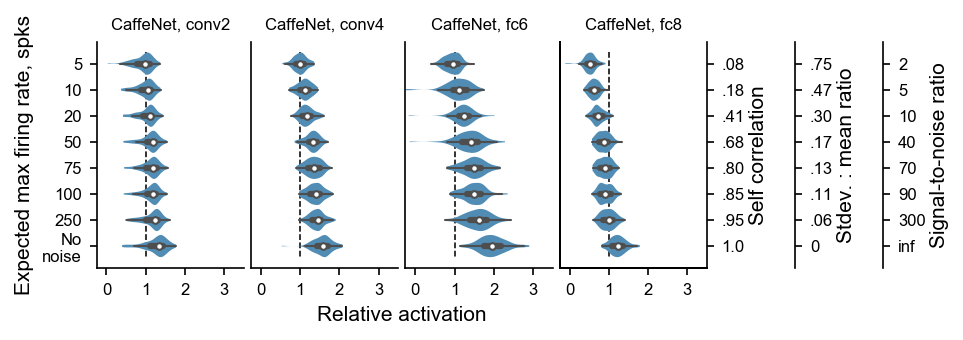

In [34]:
fig, axs = subplots(1, 4, figsize=(5.25, 2), dpi=150, sharex=True, sharey=True, squeeze=False)
axs = axs.flatten()
subplots_adjust(wspace=0.05)

for l, ax in zip(layers, axs):
    df_ = df[df['Layer'] == l]
    n_groups, ax, lgnd, hdls = violinplot2(
        data=df_, x='Rel_act', y='Stoch_scale_plot', orient='h',
        cut=0, width=.85, scale='width',
        palette=palette, ax=ax)
    ax.set_title(f'CaffeNet, {l}', fontsize=8)
    default_ax_lims(ax, n_groups, orient='h')
    ax.set_xlabel(None)

# append more y-axes to last axis
pars = [twinx(ax) for _ in range(len(stat_keys))]
ylim_ = ax.get_ylim()
for i, (par, k, fmt, k_disp) in enumerate(zip(pars, stat_keys, fmts, stat_keys_disp)):
    par.set_frame_on(True)
    par.patch.set_visible(False)
    par.spines['right'].set_visible(True)
    par.yaxis.set_ticks_position('right')
    par.yaxis.set_label_position('right')
    par.yaxis.labelpad = 2
    par.spines['right'].set_position(('axes', 1+.6*i))
    par.set_ylabel(k_disp)
    par.set_yticks(range(len(stoch_scales)))
    par.set_yticklabels(map(fmt, byl_byss_stats[k][l]))
    par.set_ylim(ylim_)
  
axs[0].set_ylabel('Expected max firing rate, spks')
axs[0].set_yticklabels(stoch_scales_disp)
for ax in axs[1:]:
    ax.set_ylabel(None)
    ax.yaxis.set_tick_params(left=False)
# joint 
ax = fig.add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', bottom=False, left=False, right=False)
ax.set_frame_on(False)
ax.set_xlabel('Relative activation')

savefig(figdir / 'stoch_scales.png', dpi=300, bbox_inches='tight')
savefig(figdir / 'stoch_scales.svg', dpi=300, bbox_inches='tight')